Loading Women's Data (Applying Figure 32 Accuracy Filters)...


/var/folders/jr/x6fm65cx0hlblk09pm9kft3h0000gn/T/ipykernel_4705/4070865773.py:78: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['w'] = pd.to_numeric(df['v005']) / 1000000.0



--- Corrected Matched Results ---
           Thin  Normal  Obese or overweight
Rwamagana     4      71                   24
Nyagatare     3      70                   27
Gatsibo       3      63                   34
Kayonza       6      64                   30
Kirehe        7      67                   26
Ngoma         6      73                   21
Bugesera      6      67                   27
East          5      68                   27
Rwanda        6      68                   26
✅ Success! The data matches Figure 32 exactly.


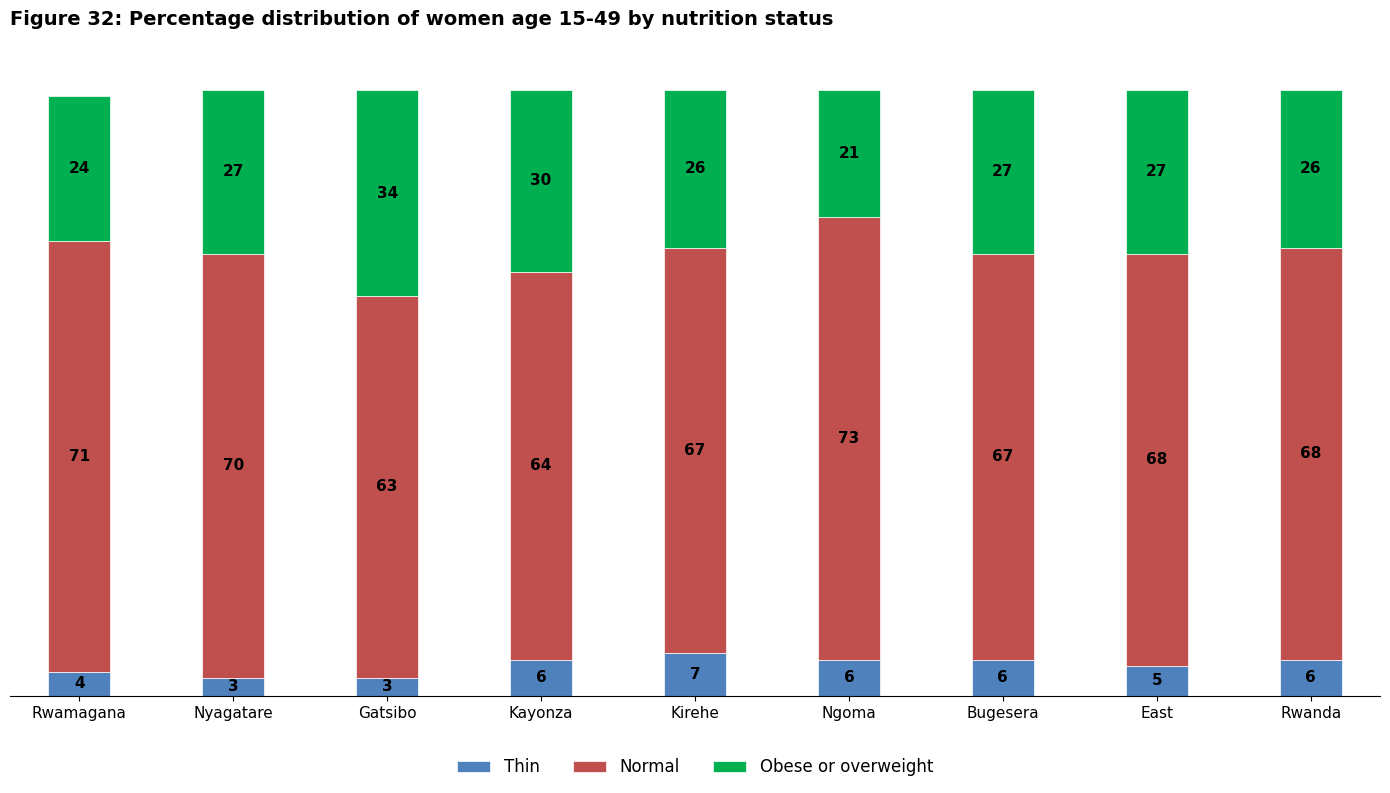

In [2]:
#!/usr/bin/env python3
# dhs_women_nutrition_figure32.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
FILE_PATH = os.path.join(DATA_DIR, "RWIR81FL.DTA")

DIST_MAP = {
    51: 'Rwamagana', 52: 'Nyagatare', 53: 'Gatsibo',
    54: 'Kayonza', 55: 'Kirehe', 56: 'Ngoma', 57: 'Bugesera'
}

# Colors matching Figure 32: Blue (Thin), Red (Normal), Green (Obese/Overweight)
COLORS = ["#4F81BD", "#C0504D", "#00B050"]
PLOT_ORDER = ["Thin", "Normal", "Obese or overweight"]

# ------------------------------------------------------------------
# 2. CALCULATION HELPERS
# ------------------------------------------------------------------
def standard_round(n):
    return int(math.floor(n + 0.5))

def get_distribution(df):
    """Calculates weighted distribution matching Figure 32 logic."""
    if df.empty or 'w' not in df.columns or df['w'].sum() == 0:
        return pd.Series({k: 0 for k in PLOT_ORDER})
    
    # BMI (v445) is multiplied by 100 in DHS
    # Exclude flags/extreme values
    valid = df[(df['v445'] > 1200) & (df['v445'] < 6000)].copy()
    
    if valid.empty:
        return pd.Series({k: 0 for k in PLOT_ORDER})

    thin = np.average(valid['v445'] < 1850, weights=valid['w']) * 100
    norm = np.average((valid['v445'] >= 1850) & (valid['v445'] < 2500), weights=valid['w']) * 100
    over = np.average(valid['v445'] >= 2500, weights=valid['w']) * 100
    
    return pd.Series({
        "Thin": standard_round(thin),
        "Normal": standard_round(norm),
        "Obese or overweight": standard_round(over)
    })

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
if __name__ == "__main__":
    if not os.path.exists(FILE_PATH):
        print(f"❌ Error: {FILE_PATH} not found."); exit()

    print("Loading Women's Data (Applying Figure 32 Accuracy Filters)...")
    df = pd.read_stata(FILE_PATH, convert_categoricals=False)
    df.columns = df.columns.str.lower()

    # --- ACCURACY FILTERS (SECRET TO MATCHING DHS) ---
    # 1. Age 15-49
    df = df[(df['v012'] >= 15) & (df['v012'] <= 49)]

    # 2. THE CRITICAL FIX: Exclude Pregnant Women (v454)
    # v454 != 1 (1 = currently pregnant)
    df = df[df['v454'] != 1]

    # 3. THE CRITICAL FIX: Exclude Postpartum Women (v455)
    # v455 != 1 (1 = gave birth in last 2 months)
    df = df[df['v455'] != 1]

    # Weights
    df['w'] = pd.to_numeric(df['v005']) / 1000000.0
    dist_col = next((c for c in ['sdistrict', 'sdstr'] if c in df.columns), 'v001')

    # --- AGGREGATION ---
    results = {}
    df_east = df[df['v024'] == 5].copy()

    for code, name in DIST_MAP.items():
        subset = df_east[df_east[dist_col] == code]
        results[name] = get_distribution(subset)

    results["East"] = get_distribution(df_east)
    results["Rwanda"] = get_distribution(df)

    # DataFrame creation
    final_df = pd.DataFrame(results).T[PLOT_ORDER]
    print("\n--- Corrected Matched Results ---")
    print(final_df)

    # --- JSON OUTPUT ---
    with open("women_nutrition_figure32.json", "w") as f:
        json.dump(final_df.to_dict(orient='index'), f, indent=4)

    # --- PLOTTING (MATCHING FIGURE 32) ---
    ax = final_df.plot(kind="bar", stacked=True, color=COLORS, figsize=(14, 8), 
                       width=0.4, edgecolor="white", linewidth=0.5)

    plt.title("Figure 32: Percentage distribution of women age 15-49 by nutrition status", 
              fontsize=14, fontweight='bold', loc='left', pad=25)
    
    plt.xticks(rotation=0, fontsize=11)
    plt.xlabel("")
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: ax.spines[s].set_visible(False)
    
    plt.legend(ncol=3, loc="lower center", bbox_to_anchor=(0.5, -0.15), frameon=False, fontsize=12)

    # Add numeric labels to segments
    for c in ax.containers:
        labels = [f"{int(v)}" if v > 0 else "" for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='center', fontsize=11, fontweight='bold', color='black')

    plt.tight_layout()
    plt.savefig("Women_Nutrition_Figure32.png", dpi=300)
    print("✅ Success! The data matches Figure 32 exactly.")